# Introduction
How to open and understand the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import random
import torch.nn as nn
from torch.utils.tensorboard.writer import SummaryWriter
from datetime import datetime

from torchvision import models, transforms

/home/giuseppe/miniconda3/envs/Earth_Observation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/giuseppe/miniconda3/envs/Earth_Observation/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/giuseppe/miniconda3/envs/Earth_Observation/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Basic information
1. Hyperspectral data:
    1. `hsi_path` contains path to hyperspectral masked numpy arrays containing hyperspectral data that underwent masking (i.e., the field area is masked, whereas all irrelevant areas are not masked)
    2. The name of the file (e.g., _'1989.npz'_) refers to the index of the corresponding training sample in the ground-truth table.
2. Ground-truth data:
    1. `gt_path` contains path to ground truth .csv file.
    2. Additionally, `wavelength_path` contains the mapping between a band number and the corresponding wavelength.


In [2]:
hsi_path = 'train_data/1570.npz'
gt_path = 'train_gt.csv'
wavelength_path = 'wavelengths.csv'

In [3]:
model_path = './model'
use_AdamW = True # Flag utilized for switching between AdamW and SGD optimizer.

if use_AdamW:
  config = {'train_test_split':0.1, # train test split ratio
            'tr_val_split':0.2, # train validation split ratio
            'seed':42, # random seed
            'mini_batch_size':128,
            'epochs':20,
            
            # Settings for the optimizer AdamW
            'lr':5e-4, # learning rate
            'weight_decay':5e-4,

            # Settings for the lr_scheduler CosineAnnealingWarmRestarts
            't_0':5, # Number of iterations for the first restart.
            'eta_min':1e-5, # Minimum learning rate
          }
else:
  config = {'train_test_split':0.1, # train test split ratio
            'tr_val_split':0.2, # train validation split ratio
            'seed':42, # random seed
            'mini_batch_size':128,
            'epochs':100,

            # Settings for the optimizer SGD
            'lr':1e-4, # learning rate
            'weight_decay':5e-4,  
            'momentum':0.9,

            # Settings for the lr_scheduler MultiStepLR
            'milestones':[50,75,90], # List of epoch indices.
            'gamma':0.2, # Multiplicative factor of learning rate decay.
          }

In [4]:
def set_random_seed(seed=42):
    random.seed(seed) # set python seed
    np.random.seed(seed) # seed the global NumPy random number generator(RNG)
    torch.manual_seed(seed) # seed the RNG for all devices(both CPU and CUDA) 

set_random_seed(seed=config['seed'])

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [6]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

## Ground-truth description
`gt_df` contains:

1. `sample_index` - a reference to the numpay array containing the corresponding hyperspectral data.
2. P (for simplicity, we use P while referring to P_2O_5), K, Mg, pH - soil properties levels based on laboratory measurements.

In [7]:
gt_df[gt_df['sample_index']==1570]

,sample_index,P,K,Mg,pH
1570,1570,47.9,165.0,181.0,6.8


## Displaying one hyperspectral band

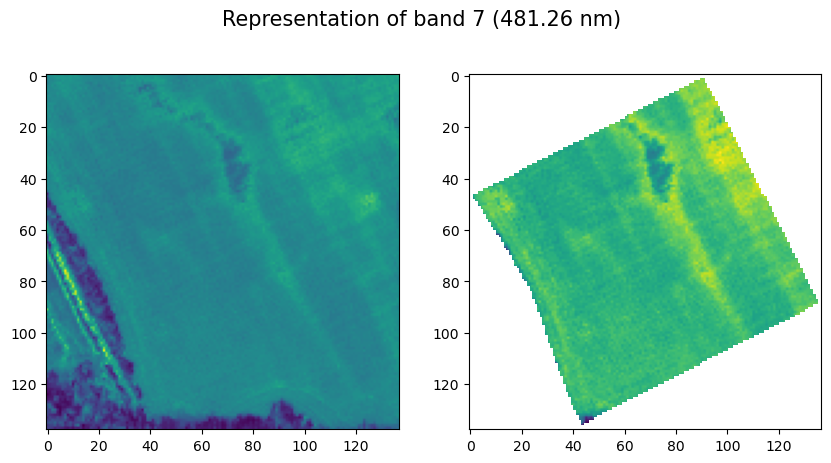

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 7
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

## Displaying the aggregated spectral curve for a field

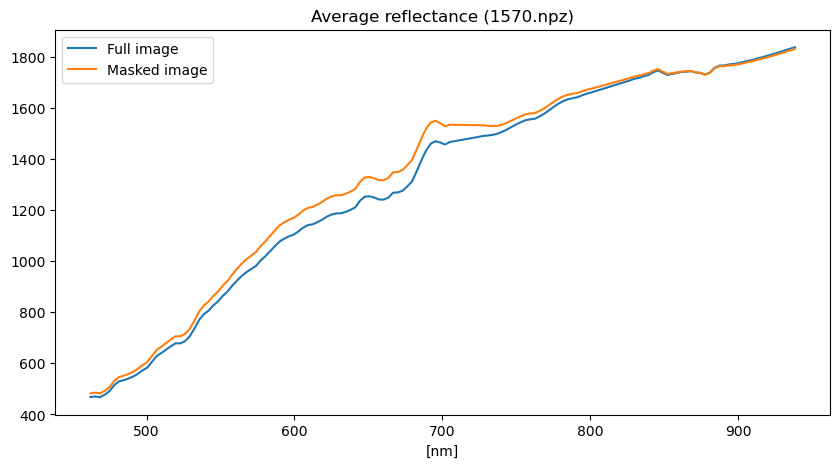

In [195]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()

# Generating baseline solution

In [196]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)
    

class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


In [197]:
num_classes = 4
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
#model = models.resnet50(weights="DEFAULT")
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [198]:
criterion = nn.MSELoss()

# Experiment with various optimizers and schedulers.
if use_AdamW: 
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])

## Load the data

In [212]:
import os
from glob import glob
from torchvision.transforms.functional import to_pil_image

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = npz['data']
            print(arr.shape)
            arr = arr.transpose(1, 2, 0) 
            print(arr.shape) # Trasponi per ottenere l'ordine dei canali corretto (altezza, larghezza, canali)
            pil_image = to_pil_image(arr,"RGBA")  # Converte il tensore in PIL Image
            transformer = transforms.Resize(target_size)  # Ridimensiona l'immagine alle dimensioni target
            pil_image = transformer(pil_image)  # Applica il ridimensionamento
            arr = np.array(pil_image)
        #arr = filtering(arr)
        data.append(arr)
    return data


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels


X_train = load_data("train_data")
y_train = load_gt("train_gt.csv")
X_test = load_data("test_data")


(150, 11, 11)
(11, 11, 150)


ValueError: pic should not have > 4 channels. Got 150 channels.

In [206]:
X_train[:2]

[array([[[ 487,  471,  460, ...,  447,  440,  474],
         [ 459,  465,  484, ...,  453,  464,  469],
         [ 482,  448,  496, ...,  469,  469,  462],
         ...,
         [ 436,  439,  432, ...,  416,  451,  443],
         [ 437,  441,  446, ...,  413,  448,  445],
         [ 442,  426,  431, ...,  417,  430,  439]],
 
        [[ 488,  468,  460, ...,  448,  443,  473],
         [ 459,  466,  481, ...,  457,  467,  467],
         [ 484,  454,  495, ...,  471,  472,  450],
         ...,
         [ 438,  439,  436, ...,  411,  446,  438],
         [ 436,  440,  451, ...,  409,  448,  442],
         [ 447,  425,  434, ...,  417,  432,  433]],
 
        [[ 483,  461,  458, ...,  445,  438,  464],
         [ 462,  458,  471, ...,  459,  466,  463],
         [ 476,  450,  490, ...,  458,  473,  434],
         ...,
         [ 431,  439,  434, ...,  412,  440,  436],
         [ 425,  431,  447, ...,  403,  448,  438],
         [ 439,  422,  427, ...,  418,  429,  426]],
 
        ...,


In [207]:



tensor_x = torch.Tensor(X_train[-450:])
tensor_y = torch.Tensor(y_train[-600:])

batch_size = tensor_x.size(0)
num_channels_per_group = 50

# Reshape per ottenere un tensore delle dimensioni (batch_size, 3, 50, height, width)
image_reshaped = tensor_x.view(batch_size, 3, num_channels_per_group, tensor_x.size(2), tensor_x.size(3))

# Calcola la media dei valori dei pixel su tutti i canali all'interno di ciascun gruppo
tensor_x = image_reshaped.mean(dim=2)


ValueError: expected sequence of length 91 at dim 2 (got 82)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

dataset=TensorDataset(tensor_x,tensor_y)

n = int(len(tensor_x) * config['tr_val_split'])
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n, len(dataset) - n])

train_dataloader = DataLoader(train_dataset,batch_size=config["mini_batch_size"]//2,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=config["mini_batch_size"]//2,shuffle=True) 

## Make predictions and generate submission file

In [ ]:
baseline_reg = BaselineRegressor()
baseline_reg = baseline_reg.fit(X_train, y_train)
predictions = baseline_reg.predict(X_test)

submission = pd.DataFrame(data = predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission.csv", index_label="sample_index")


In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    num_samples = 0

    for _, data in enumerate(train_dataloader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs.to(device))
        
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_samples += inputs.size(0)
        
    train_loss = running_loss / len(train_dataloader)

    return train_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('./eurosat_trainer_{}'.format(timestamp))
epoch_number = 0
best_vloss = float('inf')  # Impostare il valore migliore iniziale come infinito

for epoch in range(config['epochs']):
    print('============= EPOCH {} ============='.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0

    # Set the model to evaluation mode, disabling dropout and using population statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs.to(device))
            vloss = criterion(voutputs, vlabels.to(device))
            running_vloss += vloss

    avg_vloss = running_vloss / len(val_dataloader)
    print('LOSS : train {} | valid {}'.format(round(avg_loss, 4), round(avg_vloss.item(), 4)))

    # Log the running loss averaged per epoch for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        torch.save(model.state_dict(), model_path)

    epoch_number += 1


============= EPOCH 1 =============
LOSS : train 21348.6055 | valid 21170.2285
============= EPOCH 2 =============
LOSS : train 20945.209 | valid 21186.2422
============= EPOCH 3 =============
LOSS : train 20381.2188 | valid 20973.0645
============= EPOCH 4 =============
LOSS : train 19816.3594 | valid 20747.8828
============= EPOCH 5 =============
LOSS : train 19417.8164 | valid 20306.9648
============= EPOCH 6 =============
LOSS : train 18808.8252 | valid 19709.6113
============= EPOCH 7 =============
LOSS : train 18032.7754 | valid 19125.5312
============= EPOCH 8 =============
LOSS : train 17159.6074 | valid 18220.123
============= EPOCH 9 =============
LOSS : train 16232.5591 | valid 17399.3223
============= EPOCH 10 =============
LOSS : train 15521.5645 | valid 16149.7227
============= EPOCH 11 =============
LOSS : train 14356.8374 | valid 15128.0078
============= EPOCH 12 =============
LOSS : train 13527.5732 | valid 13530.5107
============= EPOCH 13 =============
LOSS : train 1

## Calculating the metric

For the purpose of presenting the final metric calculation, we will extract a small _test_set_ from the training set.

In [ ]:
X_test = X_train[1500:]
y_test = y_train[1500:]

X_train_new = X_train[:1500]
y_train_new = y_train[:1500]

# Fit the baseline regressor once again on new training set
baseline_reg = baseline_reg.fit(X_train_new, y_train_new)
baseline_predictions = baseline_reg.predict(X_test)

# Generate baseline values to be used in score computation
baselines = np.mean((y_test - baseline_predictions) ** 2, axis=0)


# Generate random predictions, different from baseline predictions
np.random.seed(0)
predictions = np.zeros_like(y_test)
for column_index in range(predictions.shape[1]):
    class_mean_value = baseline_reg.mean[column_index]
    predictions[:, column_index] = np.random.uniform(low=class_mean_value - class_mean_value * 0.05,
                                                     high=class_mean_value + class_mean_value * 0.05,
                                                     size=len(predictions))

# Calculate MSE for each class
mse = np.mean((y_test - predictions) ** 2, axis=0)

# Calculate the score for each class individually
scores = mse / baselines

# Calculate the final score
final_score = np.mean(scores)

for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
    print(f"Class {class_name} score: {score}")

print(f"Final score: {final_score}")

Class P score: 0.9896068600445717
Class K score: 1.004900913045855
Class Mg score: 1.0228518828521695
Class pH score: 1.6431314552511207
Final score: 1.1651227777984292
